In [5]:
!git clone https://github.com/saurabh-m-w/Self-Car-Driving-Track

Cloning into 'Self-Car-Driving-Track'...
remote: Enumerating objects: 12163, done.
remote: Total 12163 (delta 0), reused 0 (delta 0), pack-reused 12163
Receiving objects: 100% (12163/12163), 156.98 MiB | 22.12 MiB/s, done.
Checking out files: 100% (12160/12160), done.


In [2]:
!ls

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#import keras
import keras as keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
import cv2
import pandas as pd
import random
import ntpath
from sklearn.utils import shuffle

Using TensorFlow backend.


ImportError: Traceback (most recent call last):
  File "C:\Users\shree\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\pywrap_tensorflow.py", line 64, in <module>
    from tensorflow.python._pywrap_tensorflow_internal import *
ImportError: DLL load failed: The specified module could not be found.


Failed to load the native TensorFlow runtime.

See https://www.tensorflow.org/install/errors

for some common reasons and solutions.  Include the entire stack trace
above this error message when asking for help.

In [3]:
print(tensorflow.__version__)

2.3.0


In [7]:
datadir = 'Self-Car-Driving-Track'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', -1)
data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


,center,left,right,steering,throttle,reverse,speed
0,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_382.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_382.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_382.jpg,0.0,0.0,0.0,0.649786
1,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_670.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_670.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_670.jpg,0.0,0.0,0.0,0.627942
2,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_724.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_724.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_724.jpg,0.0,0.0,0.0,0.622910
3,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_792.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_792.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_792.jpg,0.0,0.0,0.0,0.619162
4,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_860.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_860.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_860.jpg,0.0,0.0,0.0,0.615438


In [8]:
def path_leaf(path):
  head,tail = ntpath.split(path)
  return tail

data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2018_07_16_17_11_43_382.jpg,left_2018_07_16_17_11_43_382.jpg,right_2018_07_16_17_11_43_382.jpg,0.0,0.0,0.0,0.649786
1,center_2018_07_16_17_11_43_670.jpg,left_2018_07_16_17_11_43_670.jpg,right_2018_07_16_17_11_43_670.jpg,0.0,0.0,0.0,0.627942
2,center_2018_07_16_17_11_43_724.jpg,left_2018_07_16_17_11_43_724.jpg,right_2018_07_16_17_11_43_724.jpg,0.0,0.0,0.0,0.622910
3,center_2018_07_16_17_11_43_792.jpg,left_2018_07_16_17_11_43_792.jpg,right_2018_07_16_17_11_43_792.jpg,0.0,0.0,0.0,0.619162
4,center_2018_07_16_17_11_43_860.jpg,left_2018_07_16_17_11_43_860.jpg,right_2018_07_16_17_11_43_860.jpg,0.0,0.0,0.0,0.615438


In [9]:
num_bins = 25
hist, bins = np.histogram(data['steering'], num_bins)
print(bins)    #stering angles

[-1.   -0.92 -0.84 -0.76 -0.68 -0.6  -0.52 -0.44 -0.36 -0.28 -0.2  -0.12
 -0.04  0.04  0.12  0.2   0.28  0.36  0.44  0.52  0.6   0.68  0.76  0.84
  0.92  1.  ]


<BarContainer object of 25 artists>

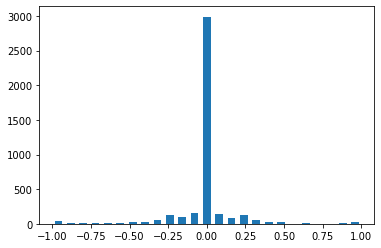

In [10]:
center = (bins[:-1]+bins[1:])*0.5
plt.bar(center,hist,width=0.05)

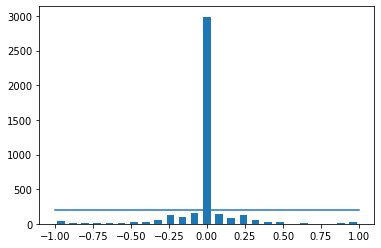

In [11]:
num_bins = 25
samples_per_bin = 200
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [12]:
print('total data:',len(data))
remove_list=[]
for j in range(num_bins):
  list_=[]
  for i in range(len(data['steering'])):
    if data['steering'][i]>=bins[j] and data['steering'][i]<=bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)
print('removed: ',len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))

total data: 4053
removed:  2790
remaining: 1263


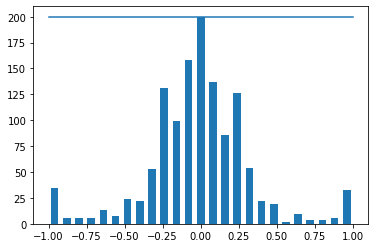

In [13]:
hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [14]:
print(data.iloc[1])

center      center_2018_07_16_17_11_44_485.jpg
left        left_2018_07_16_17_11_44_485.jpg  
right       right_2018_07_16_17_11_44_485.jpg 
steering   -0.25                              
throttle    0.863326                          
reverse     0                                 
speed       2.17305                           
Name: 13, dtype: object


In [15]:
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

image_paths, steerings = load_img_steering(datadir + '/IMG', data)

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))

Training Samples: 1010
Valid Samples: 253


Text(0.5, 1.0, 'Validation set')

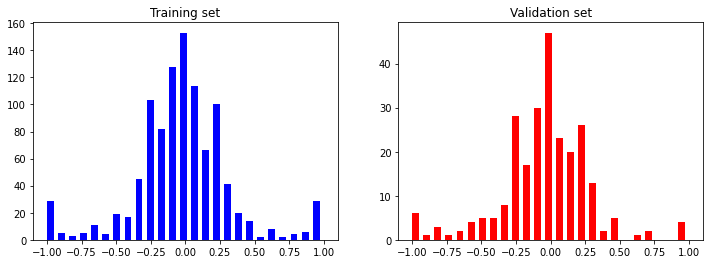

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

In [18]:
def img_preprocess(img):
  img=mpimg.imread(img)
  img = img[60:135,:,:]
  img=cv2.cvtColor(img,cv2.COLOR_RGB2YUV)  #Y-Luminosity or brightness UV-chromium
  img=cv2.GaussianBlur(img,(3,3),0) 
  img=cv2.resize(img,(200,66))
  img=img/255
  return img



Text(0.5, 1.0, 'Preprocessed Image')

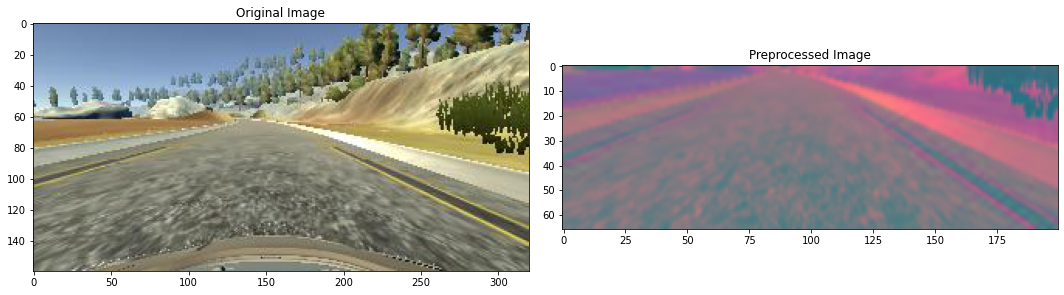

In [19]:
image = image_paths[100]
original_img =  mpimg.imread(image)
preprocessed_img = img_preprocess(image)

fig,axs=plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()
axs[0].imshow(original_img)
axs[0].set_title('Original Image')

fig.tight_layout()
axs[1].imshow(preprocessed_img)
axs[1].set_title('Preprocessed Image')


In [20]:
X_train=np.array(list(map(img_preprocess,X_train)))
X_valid = np.array(list(map(img_preprocess,X_valid))) 

(1010, 66, 200, 3)


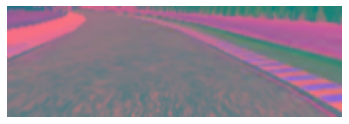

In [21]:
plt.imshow(X_train[random.randint(0,len(X_train)-1)])
plt.axis('off')
print(X_train.shape)

In [28]:

def nvidia_model():
  model = Sequential()
  model.add(Convolution2D(24, 5, 2, input_shape = (66, 200, 3), activation = 'elu'))
  model.add(Convolution2D(36, 5, 2, activation = 'elu'))
  model.add(Convolution2D(48, 5, 2, activation = 'elu'))
  model.add(Convolution2D(64, 3, activation = 'elu'))
  model.add(Convolution2D(64, 3, activation = 'elu'))
#   model.add(Dropout(0.5))
  
  
  model.add(Flatten())
  
  model.add(Dense(100, activation = 'elu'))
#   model.add(Dropout(0.5))
  
  model.add(Dense(50, activation = 'elu'))
#   model.add(Dropout(0.5))
  
  model.add(Dense(10, activation = 'elu'))
#   model.add(Dropout(0.5))

  model.add(Dense(1))
  
  optimizer = Adam(lr=1e-3)
  model.compile(loss='mse', optimizer=optimizer)
  return model


In [29]:
model = nvidia_model()
print(model.summary())


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 100)              

In [30]:
history = model.fit(X_train,y_train,epochs=30,validation_data=(X_valid,y_valid),batch_size=100,verbose=1,shuffle=1)

Epoch 1/30
11/11 [==============================] - 6s 555ms/step - loss: 0.8767 - val_loss: 0.1459
Epoch 2/30
11/11 [==============================] - 6s 538ms/step - loss: 0.1381 - val_loss: 0.1013
Epoch 3/30
11/11 [==============================] - 6s 544ms/step - loss: 0.1192 - val_loss: 0.1026
Epoch 4/30
11/11 [==============================] - 6s 547ms/step - loss: 0.1212 - val_loss: 0.1063
Epoch 5/30
11/11 [==============================] - 6s 541ms/step - loss: 0.1238 - val_loss: 0.1503
Epoch 6/30
11/11 [==============================] - 6s 543ms/step - loss: 0.1390 - val_loss: 0.1027
Epoch 7/30
11/11 [==============================] - 6s 541ms/step - loss: 0.1224 - val_loss: 0.1059
Epoch 8/30
11/11 [==============================] - 6s 547ms/step - loss: 0.1213 - val_loss: 0.1014
Epoch 9/30
11/11 [==============================] - 6s 540ms/step - loss: 0.1200 - val_loss: 0.0999
Epoch 10/30
11/11 [==============================] - 6s 538ms/step - loss: 0.1149 - val_loss: 0.0962

Text(0.5, 0, 'Epoch')

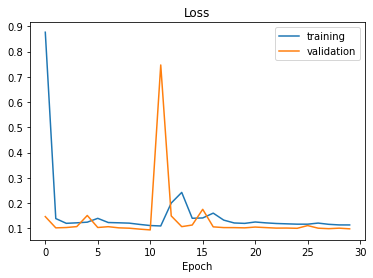

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [32]:
model.save('model.h5')

In [33]:

from google.colab import files
files.download('model.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!pip show tensorflow

Name: tensorflow
Version: 2.3.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: gast, protobuf, absl-py, termcolor, google-pasta, wheel, keras-preprocessing, opt-einsum, tensorboard, scipy, astunparse, grpcio, numpy, h5py, tensorflow-estimator, six, wrapt
Required-by: fancyimpute
